# Semestrální práce na textovou analytiku - Tým 10

Technické řešení k semestrální práci

## Načtení knihoven

In [1]:
import pandas as pd
import seaborn as sns
import spacy

## Načtení a úprava dat

In [2]:
df = pd.read_csv("Hotel_Reviews.csv", 
                 index_col=False, 
                 usecols=['Reviewer_Nationality', 'Hotel_Name', 'Average_Score', 'Tags', 'Negative_Review', 'Reviewer_Score', 'Reviewer_Nationality', 'Positive_Review'], 
                 dtype={'Reviewer_Nationality':"string", 'Hotel_Name':"string", 'Average_Score':"string", 'Negative_Review':"string", 'Reviewer_Nationality':"string", 'Positive_Review':"string", 'Tags':"string"})

In [67]:
Average_Score = df["Average_Score"].str.slice(stop=1)
Average_Score = Average_Score.astype(int)
df["Average_Score"] = Average_Score

In [4]:
h1 = df['Tags'].str.replace('"', '')
h1 = h1.str.replace("'", '')
h1 = h1.str.replace("[", '')
h1 = h1.str.replace("]", '')
h1 = h1.str.split(',')

In [5]:
tags = []
for i in h1:
    for j in i:
        tags.append(j)

In [8]:
Tags_unique = []
for tag in tags:
    if tag not in Tags_unique:
        Tags_unique.append(tag)
Tags_string = ""
Tags_string = Tags_string.join(Tags_unique)
words = Tags_string.split()
tags_final = " ".join(sorted(set(words), key=words.index))

## Seznámení se s daty

Aby jsme měli představu kolik máme záznamů, jestli jsou převážně pozitivní či negativní

<AxesSubplot:xlabel='Average_Score', ylabel='count'>

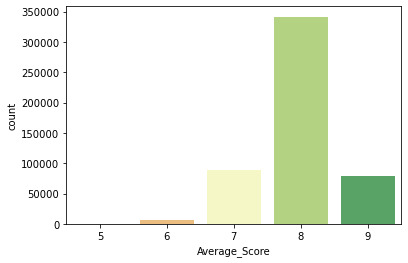

In [19]:
sns.countplot(x="Average_Score", data=df, palette="RdYlGn")

<AxesSubplot:xlabel='sentiment', ylabel='count'>

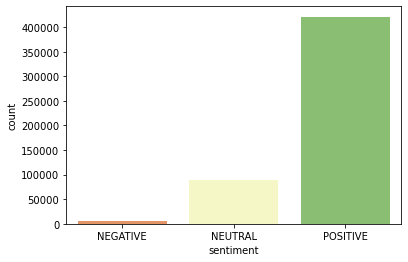

In [20]:
df["sentiment"] = pd.cut(df["Average_Score"], 
                   bins=[0,6.9,7,9], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
sns.countplot(x="sentiment", data=df, palette="RdYlGn")

In [21]:
df.groupby("sentiment").count()

Average_Score  Hotel_Name  Reviewer_Nationality  Negative_Review  \
sentiment                                                                     
NEGATIVE            5665        5665                  5665             5665   
NEUTRAL            88982       88982                 88982            88982   
POSITIVE          421091      421091                421091           421091   

           Positive_Review  Reviewer_Score    Tags  
sentiment                                           
NEGATIVE              5665            5665    5665  
NEUTRAL              88982           88982   88982  
POSITIVE            421091          421091  421091

## Analýza entit

Z textové vstupu cestovatele analuzujeme entity pro budoucí použití.

In [22]:
text_content = '''Family with two children. They enjoy swimming in the pool, water parks and various excursions into nature.'''
print(text_content)

Family with two children. They enjoy swimming in the pool, water parks and various excursions into nature.


In [23]:
from google.cloud import language_v1
from google.oauth2 import service_account
creds = service_account.Credentials.from_service_account_file('./credentials.json')
client = language_v1.LanguageServiceClient(credentials=creds)
language = "en"
type_ = language_v1.Document.Type.PLAIN_TEXT
encoding_type = language_v1.EncodingType.UTF8
document = {"content": text_content, "type_": type_, "language": language}

In [24]:
def analyze_entity(text_content):
    language = "en"
    type_ = language_v1.Document.Type.PLAIN_TEXT
    encoding_type = language_v1.EncodingType.UTF8
    document = {"content": text_content, "type_": type_, "language": language}
    response = client.analyze_entities(request = {'document': document, 'encoding_type': encoding_type})
    return response

In [25]:
response = analyze_entity(text_content)
for entity in response.entities:
    print(u"Název entity: {} - Typ entity: {} - Skóre: {}".format(
        entity.name,
        language_v1.Entity.Type(entity.type_).name,
        entity.salience))

Název entity: Family - Typ entity: PERSON - Skóre: 0.5514742136001587
Název entity: children - Typ entity: PERSON - Skóre: 0.23970159888267517
Název entity: pool - Typ entity: LOCATION - Skóre: 0.08356088399887085
Název entity: excursions - Typ entity: EVENT - Skóre: 0.05831781029701233
Název entity: nature - Typ entity: OTHER - Skóre: 0.04107389971613884
Název entity: water parks - Typ entity: LOCATION - Skóre: 0.02587161399424076
Název entity: two - Typ entity: NUMBER - Skóre: 0.0


## Podobnost slov

Porovnání entity z předešlé analýzy s tagy Couple Leisure Business Group Solo Children Family Twin. Nejdříve ukázková tabulka s omezeným počtem tagů a pak tabulka se všemi tagy.

In [10]:
nlp = spacy.load("en_core_web_md")
doc = nlp("Family children pool excursions nature")
tag = nlp("Family Children View Leisure Business Pet Group Smoking Spa Pool WiFi")
similarity_map = pd.DataFrame(columns=doc)
for token in tag:
    for token2 in doc:
        similarity_map.loc[token, token2] = token.similarity(token2)
similarity_map.apply(pd.to_numeric).style.background_gradient(cmap ='PuRd')

In [12]:
nlp = spacy.load("en_core_web_md")
doc = nlp("Family children pool excursions nature")
tagy = nlp(tags_final)
similarity_map = pd.DataFrame(columns=doc)
for token in tagy:
    for token2 in doc:
        similarity_map.loc[token, token2] = token.similarity(token2)
similarity_map.apply(pd.to_numeric).style.background_gradient(cmap ='BuGn')

<ipython-input-12-1590b4015d95>:7: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity_map.loc[token, token2] = token.similarity(token2)


## Výběr dle národnosti

V případě kdy nám cestovatel řekne svou národnost, podívat se jaké hoteli jsou jeho národností nejlépe hodnoceni. Nejedná se však výhradně o textovou analytiku a tak jsme se tomuto směru, dále nevěnovali.

In [27]:
nationaily=df[df['Reviewer_Nationality'].str.contains("Isle of Man")]

In [28]:
nationaily.sort_values(by='Reviewer_Score', ascending=False)

Average_Score                            Hotel_Name  \
320067              7                Novotel Amsterdam City   
454996              9            Hilton London Canary Wharf   
97776               8  Radisson Blu Edwardian Mercer Street   
97298               9              citizenM London Bankside   
449202              9                      Hotel Capricorno   
...               ...                                   ...   
131472              6               Bloomsbury Palace Hotel   
2314                7      The Park Grand London Paddington   
91916               7                  Park Lane Mews Hotel   
252311              8                             TheWesley   
42662               7               Hilton London Hyde Park   

       Reviewer_Nationality  \
320067         Isle of Man    
454996         Isle of Man    
97776          Isle of Man    
97298          Isle of Man    
449202         Isle of Man    
...                     ...   
131472         Isle of Man    
2314           Isle of Man    
91916          Isle of Man    
252311         Isle of Man    
42662          Isle of Man    

                                          Negative_Review  \
320067                                        No Negative   
454996                                        No Negative   
97776                                         No Negative   
97298                                 Nothing not to like   
449202                                        No Negative   
...                                                   ...   
131472   The heat was unbearable and I couldn t sleep ...   
2314     Size of the bedrooms were small Had to phone ...   
91916    Got into a dirty bed full of stale breadcrumb...   
252311   Firstly I was put in a superior deluxe room o...   
42662    Horrendous meal serve warm red wine food if p...   

                                          Positive_Review  Reviewer_Score  \
320067                             Location Staff helpful            10.0   
454996   Great customer service and special touches fo...            10.0   
97776    Once again the service care from all members ...            10.0   
97298                                    Loved everything            10.0   
449202   Just a lovely small modern hotel very conveni...            10.0   
...                                                   ...             ...   
131472                                        No Positive             4.6   
2314     The staff were friendly The day are holiday e...             4.6   
91916                                            Location             4.2   
252311   I liked the location of the hotel and its pro...             3.8   
42662                                         No Positive             3.3   

                                                     Tags sentiment  
320067  [' Business trip ', ' Group ', ' Executive Del...   NEUTRAL  
454996  [' Leisure trip ', ' Group ', ' Twin Deluxe Ro...  POSITIVE  
97776   [' Family with young children ', ' Superior Do...  POSITIVE  
97298   [' Leisure trip ', ' Solo traveler ', ' Double...  POSITIVE  
449202  [' Leisure trip ', ' Group ', ' Double Room wi...  POSITIVE  
...                                                   ...       ...  
131472  [' Leisure trip ', ' Group ', ' Single Room ',...  NEGATIVE  
2314    [' Leisure trip ', ' Couple ', ' Deluxe Double...   NEUTRAL  
91916   [' Business trip ', ' Couple ', ' Double Room ...   NEUTRAL  
252311  [' Leisure trip ', ' Solo traveler ', ' Superi...  POSITIVE  
42662   [' Leisure trip ', ' Couple ', ' Deluxe King G...   NEUTRAL  

[405 rows x 8 columns]

In [29]:
pd.pivot_table(nationaily, 
               values="Reviewer_Score", 
               aggfunc=["count", "mean"], 
               index="Hotel_Name", 
               margins=True)

count           mean
                              Reviewer_Score Reviewer_Score
Hotel_Name                                                 
Aloft London Excel                         5       9.680000
Amadi Panorama Hotel                       1       8.300000
Amba Hotel Charing Cross                   2       9.800000
Andaz London Liverpool Street              1       9.600000
Apex City Of London Hotel                  1       9.200000
...                                      ...            ...
citizenM London Bankside                   2       9.400000
citizenM London Shoreditch                 1       8.300000
citizenM Tower of London                   4       8.875000
every hotel Piccadilly                     1      10.000000
All                                      405       8.402963

[249 rows x 2 columns]